In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchmetrics.functional import structural_similarity_index_measure as ssim
#import cv2
import os
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import find_peaks



# Inspecting the data

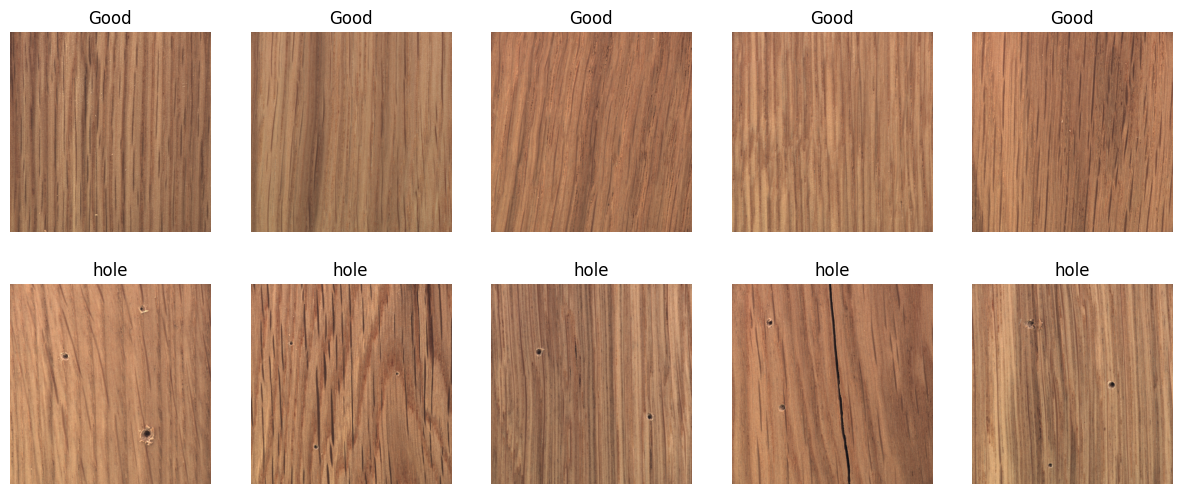

In [6]:
def display_good_and_anomalous_images(base_path, anomaly_type, num_images=5):
    # Paths to good and anomalous images
    good_path = os.path.join(base_path, "train", "good")
    anomaly_path = os.path.join(base_path, "test", anomaly_type)

    # List all images in the directories
    good_images = os.listdir(good_path)
    anomaly_images = os.listdir(anomaly_path)

    # Randomly select images to display
    selected_good_images = random.sample(good_images, min(num_images, len(good_images)))
    selected_anomaly_images = random.sample(anomaly_images, min(num_images, len(anomaly_images)))

    # Plot the images
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    
    # Display good images
    for i, img_name in enumerate(selected_good_images):
        img_path = os.path.join(good_path, img_name)
        img = plt.imread(img_path)
        axes[0, i].imshow(img)
        axes[0, i].axis("off")
        axes[0, i].set_title("Good")

    # Display anomalous images
    for i, img_name in enumerate(selected_anomaly_images):
        img_path = os.path.join(anomaly_path, img_name)
        img = plt.imread(img_path)
        axes[1, i].imshow(img)
        axes[1, i].axis("off")
        axes[1, i].set_title(anomaly_type)

    plt.show()

base_path = "mvtec_anomaly_detection/wood" # cooked path
# provide other anomaly types to see the rest
display_good_and_anomalous_images(base_path,  anomaly_type="hole", num_images=5)


In [7]:
# Define model from Bergmann et al
class AutoEncoder(nn.Module):
    def __init__(self, d):
        super(AutoEncoder, self).__init__()

        # Encoder 
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Conv1
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),  # Conv2
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # Conv3
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Conv4
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # Conv5
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Conv6
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),  # Conv7
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  # Conv8
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, d, kernel_size=8, stride=1, padding=0)     # Conv9
        )

        # Decoder (reverse of the encoder)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(d, 32, kernel_size=8, stride=1, padding=0),     # Deconv9
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding=1),    # Deconv8
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=1, padding=1),   # Deconv7
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # Deconv6
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),    # Deconv5
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # Deconv4
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),    # Deconv3
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),    # Deconv2
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # Deconv1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    
# Dataset for training if you specify is_train=True
# Dataset for test if is_train = false
class MVTecDataset(Dataset):
    def __init__(self, root_dir, transform, is_train, defect_types):

        self.root_dir = root_dir
        self.is_train = is_train
        self.transform = transform
        self.defect_types = defect_types
        
        if is_train:
            self.image_paths = self._get_image_paths('train/good')
        else:
            self.image_paths = self._get_image_paths('test/good')
            self.image_paths.extend(self._get_defect_image_paths('test'))
            
    def _get_image_paths(self, subset):
        path = os.path.join(self.root_dir, subset)
        if not os.path.exists(path):
            return []
        return [os.path.join(path, f) for f in os.listdir(path) if f.endswith(('.png', '.jpg'))]
    
    def _get_defect_image_paths(self, subset):
        paths = []
        
        for defect in self.defect_types:
            defect_path = os.path.join(self.root_dir, subset, defect)
            paths.extend([os.path.join(defect_path, f) for f in os.listdir(defect_path)])
        return paths
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        # 1 for good; 0 for anomaly
        label = 1 if 'good' in img_path else 0
        return image, label


# Anomalous images only    
class AnomalousMVTecDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        
        # Get all subfolders EXCEPT the good one
        test_path = os.path.join(root_dir, 'test')
        subfolders = [f.path for f in os.scandir(test_path) if f.is_dir()]
        for folder in subfolders:
            if not folder.endswith('good'):
                self.image_paths.extend(self._get_image_paths(os.path.join('test', os.path.basename(folder))))
            
    def _get_image_paths(self, subset):
        path = os.path.join(self.root_dir, subset)
        if not os.path.exists(path):
            return []
        return [os.path.join(path, f) for f in os.listdir(path) if f.endswith(('.png', '.jpg'))]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        # 1 for good; 0 for anomaly
        label = 1 if 'good' in img_path else 0
        return image, label
    
# Class that perform the data augment operation
class RandomZoom:
    def __init__(self, zoom_range=(0.8, 1.0), num_augmentations=3):

        self.zoom_range = zoom_range
        self.num_augmentations = num_augmentations

    def __call__(self, img):
        augmented_images = []
        
        c, h, w = img.shape
        
        img = img.unsqueeze(0)
        
        for _ in range(self.num_augmentations):
            # Randomly select a zoom factor
            zoom_factor = random.uniform(*self.zoom_range)
            
            # Calculate new dimensions for cropping
            crop_height = int(h * zoom_factor)
            crop_width = int(w * zoom_factor)
            
            crop_height = min(crop_height, h)
            crop_width = min(crop_width, w)
            
            top = random.randint(0, h - crop_height) if h > crop_height else 0
            left = random.randint(0, w - crop_width) if w > crop_width else 0
            
            cropped = img[:, :, top:top+crop_height, left:left+crop_width]
            
            resized = F.interpolate(cropped, size=(h, w), mode='bilinear', align_corners=False)
            
            augmented_images.append(resized.squeeze(0))
            
        return augmented_images
    
# Wrapper around the MVTec dataset to perform the zoom operation
class ZoomedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None, zoom_range=(0.6, 0.9), num_augmentations=10):
        self.dataset = dataset
        self.transform = transform
        self.random_zoom = RandomZoom(zoom_range, num_augmentations)

    def __len__(self):
        return len(self.dataset) * self.random_zoom.num_augmentations

    def __getitem__(self, idx):

        original_idx = idx // self.random_zoom.num_augmentations
        augmentation_idx = idx % self.random_zoom.num_augmentations
        img, label = self.dataset[original_idx]
        
        # Do the augmentation here
        # Extremely inefficient to but it works
        augmented_images = self.random_zoom(img)
        img_augmented = augmented_images[augmentation_idx]
        
        return img_augmented, label

In [8]:
from datetime import datetime


def save_model(model, name):
    save_path = os.path.normpath("../trained_models")
    
    # Ensure the directory exists
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
    
    # Create the name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    path = os.path.join(save_path, f"{timestamp}_{name}.pth")
    
    # Save the model
    try:
        torch.save(model.state_dict(), path)
        print(f"Model saved successfully at {path}")
    except Exception as e:
        print(f"Error saving model: {e}")

# Load the autoencoder
def load_model(path, latent_space):
        model = AutoEncoder(latent_space)
        model.load_state_dict(torch.load(path))
        return model


def train_autoencoder(model, train_loader, test_loader, num_epochs, flavor_text, learning_rate=1e-4, weight_decay=1e5, device='cpu'):
    seed = torch.seed()
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_losses = []
    validation_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        val_loss = 0
        
        #tqdm gives nice terminal display
        for batch_data, _ in tqdm(train_loader, desc=f'Train Epoch {epoch+1}/{num_epochs}'):
            data = batch_data.to(device)
            reconstructed = model(data)
            
            loss = torch.nn.MSELoss()(reconstructed, data)
            #loss = ssim_loss(reconstructed, data, device=device).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        with torch.no_grad():
            for test_batch, _ in tqdm(test_loader, desc=f'Test Epoch {epoch+1}/{num_epochs}'):
                data = test_batch.to(device)
                reconstructed = model(data)
                
                vali_loss = torch.nn.MSELoss()(reconstructed, data)
                #vali_loss = ssim_loss(reconstructed, data, device=device).mean()  

                val_loss += vali_loss.sum()
            
            validation_losses.append(val_loss / len(test_loader))    
        
        # Save model at intervals
        if (epoch % 20) == 0 and epoch > 21 or epoch == num_epochs - 1:
            save_model(model, f"{flavor_text}_at_epoch_{epoch}_seed_{seed}")
    return train_losses, validation_losses


# Not used currently
def ssim_loss(original, recon, device='cpu'):

    losses = []
    for img, rec in zip(original, recon):
        if not rec.requires_grad:
            rec.requires_grad_(True)
        # Calculate SSIM and convert to loss
        loss = 1 - ssim(img.unsqueeze(0), rec.unsqueeze(0))
        losses.append(loss)  
    return torch.stack(losses).to(device)



In [10]:
# Finds the anomaly threshold by calculating the mean
def get_anomaly_value(model, test_loader, device='cpu'):
    model.eval()
    errors = []

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            data = batch_data.to(device)
            
            reconstructed = model(data)
            
            # error = ssim_loss(reconstructed, data, device=device).mean()  
            error = torch.nn.MSELoss()(reconstructed, data)
            errors.append(error)

    seperator = sum(errors) / len(errors)
    return seperator

# needed to display stuff etc
# goes through the provided data_loader and returns the models predictions on every sample
def get_predictions(model, loader, threshold, device='cpu', return_all_images=False):

    model.eval()
    all_images = []
    predictions = []
    true_labels = []
    reconstruction_errors = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            reconstructed = model(images)
            if return_all_images:
                all_images.extend(images.cpu())

            for (i, r, l) in zip(images, reconstructed, labels):
                
                error = torch.nn.MSELoss()(r, i)
                #error = 1 - ssim(i.unsqueeze(0), r.unsqueeze(0))
                reconstruction_errors.append(error.cpu().numpy())
            
                # Classify as anomaly if reconstruction error > threshold
                pred = (error <= threshold).float().cpu().numpy()
                predictions.append(pred)
            
                # Convert labels to binary (1: good, 0: anomaly)
                true_labels.append(l.cpu().numpy())
    
    # Convert lists to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    reconstruction_errors = np.array(reconstruction_errors)
    if return_all_images:
        return all_images, predictions, true_labels, reconstruction_errors
    return predictions, true_labels, reconstruction_errors

# Just plotting method
def plot_original_and_reconstructed_with_anomalies(model, data_loader, device='cpu', num_images=1):
    model.eval()  
    normal_images = []
    normal_reconstructions = []
    anomalous_images = []
    anomalous_reconstructions = []

    with torch.no_grad():
        for batch_data, labels in data_loader:
            batch_data = batch_data.to(device)
            reconstructed = model(batch_data)
            batch_data = batch_data.cpu().numpy()
            reconstructed = reconstructed.cpu().numpy()
            labels = labels.cpu().numpy()
            
            # Separate normal and anomalous images
            for i in range(len(labels)):
                if labels[i] == 1 and len(normal_images) < num_images:
                    normal_images.append(batch_data[i])
                    normal_reconstructions.append(reconstructed[i])
                elif labels[i] == 0 and len(anomalous_images) < num_images:
                    anomalous_images.append(batch_data[i])
                    anomalous_reconstructions.append(reconstructed[i])
            
            # Stop if we have enough
            if len(normal_images) >= num_images and len(anomalous_images) >= num_images:
                break
    
    # Plot the images
    fig, axes = plt.subplots(num_images * 2, 2, figsize=(6, num_images * 6))
    for i in range(num_images):
        # Normal images
        axes[2 * i, 0].imshow(normal_images[i].squeeze(), cmap='gray')  
        axes[2 * i, 0].set_title("Normal: Original")
        axes[2 * i, 0].axis('off')

        axes[2 * i, 1].imshow(normal_reconstructions[i].squeeze(), cmap='gray')  #
        axes[2 * i, 1].set_title("Normal: Reconstructed")
        axes[2 * i, 1].axis('off')
        
        # Anomalous images
        axes[2 * i + 1, 0].imshow(anomalous_images[i].squeeze(), cmap='gray')  
        axes[2 * i + 1, 0].set_title("Anomalous: Original")
        axes[2 * i + 1, 0].axis('off')

        axes[2 * i + 1, 1].imshow(anomalous_reconstructions[i].squeeze(), cmap='gray')  
        axes[2 * i + 1, 1].set_title("Anomalous: Reconstructed")
        axes[2 * i + 1, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Create plot
def plot_reconstruction_error1(threshold, recon_error, labels, pred ):
    reconstruction_errors = np.array(recon_error)
    labels = np.array(labels)
    predictions = np.array(pred)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for idx, (error, label, prediction) in enumerate(zip(reconstruction_errors, labels, predictions)):
        if label == prediction:
            color = 'green'
        else:
            color = 'red'
        
        # Marker style: 'o' for "good" and 'x' for "anomaly"
        marker = 'o' if label == 1 else 'x'
        
        ax.scatter(idx, error, c=color, marker=marker)
    
    # Threshold line
    ax.axhline(y=threshold, color='blue', linestyle='--', label='Threshold')
    
    # Legend stuff
    plt.scatter([], [], c='k', marker='o', label='normal')
    plt.scatter([], [], c='k', marker='x', label='anomaly')
    plt.scatter([], [], c='#2ecc71', marker='s', label='correct')
    plt.scatter([], [], c='#e74c3c', marker='s', label='wrong')
    plt.legend()
    
    # Labels and legend
    ax.set_title("Anomaly Detection")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Reconstruction Error")

    plt.show()

# find threshold based on the probablity distributions of the errors
def find_optimal_threshold(model, good_loader, anomaly_loader, device='cpu', num_bins=50, visualization_path=None):

    model.eval()
    good_errors = []
    anomaly_errors = []
    
    # Calculate reconstruction errors for good samples
    with torch.no_grad():
        for images, _ in good_loader:
            images = images.to(device)
            reconstructed = model(images)
            for img, rec in zip(images, reconstructed):
                error = torch.nn.MSELoss()(rec, img)
                good_errors.append(error.cpu().numpy())
    
    # Calculate reconstruction errors for anomaly samples
    with torch.no_grad():
        for images, _ in anomaly_loader:
            images = images.to(device)
            reconstructed = model(images)
            for img, rec in zip(images, reconstructed):
                error = torch.nn.MSELoss()(rec, img)
                anomaly_errors.append(error.cpu().numpy())
    
    good_errors = np.array(good_errors)
    anomaly_errors = np.array(anomaly_errors)
    
    # Fit normal distributions to both sets of errors
    good_mean, good_std = stats.norm.fit(good_errors)
    anomaly_mean, anomaly_std = stats.norm.fit(anomaly_errors)
    
    # stuff for plotting
    x = np.linspace(min(good_errors.min(), anomaly_errors.min()),
                    max(good_errors.max(), anomaly_errors.max()),
                    1000)
    good_dist = stats.norm.pdf(x, good_mean, good_std)
    anomaly_dist = stats.norm.pdf(x, anomaly_mean, anomaly_std)
    
    # Find intersection 
    y_diff = good_dist - anomaly_dist
    intersection_indices = np.where(np.diff(np.signbit(y_diff)))[0]
    
    if len(intersection_indices) > 0:
        # If distributions intersect, use the intersection point as threshold
        optimal_threshold = x[intersection_indices[0]]
    else:
        # If no intersection, use midpoint between means
        optimal_threshold = (good_mean + anomaly_mean) / 2
    
    # Plotting stuff
    plt.figure(figsize=(12, 8))
    
    plt.hist(good_errors, bins=num_bins, density=True, alpha=0.6, color='green', 
             label='Good Samples')
    plt.hist(anomaly_errors, bins=num_bins, density=True, alpha=0.6, color='red',
             label='Anomaly Samples')
    
    plt.plot(x, good_dist, 'g-', lw=2, label='Good Samples (fitted)')
    plt.plot(x, anomaly_dist, 'r-', lw=2, label='Anomaly Samples (fitted)')
    
    plt.axvline(x=optimal_threshold, color='blue', linestyle='--', 
                label=f'Threshold: {optimal_threshold:.6f}')
    
    plt.title('Reconstruction Error Distributions')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    stats_text = (f'Good samples: μ={good_mean:.6f}, σ={good_std:.6f}\n'
                 f'Anomaly samples: μ={anomaly_mean:.6f}, σ={anomaly_std:.6f}')
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    if visualization_path:
        plt.savefig(visualization_path)
        plt.close()
    else:
        plt.show()
    
    return optimal_threshold, good_errors, anomaly_errors

# Setup train, test loader and hyperparameters

In [11]:
# Path to 'good' training images for bottle category
# Have to download the dataset yourselves if you wanna run it
path = "mvtec_anomaly_detection/wood/"

wood_defects = ["color", "combined", "hole", "liquid", "scratch"]

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(0.5, 0.5)
])

# For training
train_dataset = MVTecDataset(path, transform, is_train=True, defect_types=wood_defects)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# For testing
test_dataset = MVTecDataset(path, transform, is_train=False, defect_types=wood_defects)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Anomaly images only
anomalous_test_dataset = AnomalousMVTecDataset(path, transform)
anomalous_test_loader = DataLoader(anomalous_test_dataset, batch_size=16, shuffle=True)

# Data augmented loader for training
zoom_dataset = ZoomedDataset(train_dataset, transform, num_augmentations=3)
zoom_train_loader = DataLoader(zoom_dataset, batch_size=16, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ADAM_LR = 2e-4
weight_decay = 1e-5
latent_space = 100

Test Epoch 41/200: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Model saved successfully at ..\trained_models\20250109_134229_SSIM_200_at_epoch_40_seed_1270874578260000.pth


Test Epoch 61/200: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Model saved successfully at ..\trained_models\20250109_135606_SSIM_200_at_epoch_60_seed_1270874578260000.pth


Test Epoch 81/200: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Model saved successfully at ..\trained_models\20250109_140942_SSIM_200_at_epoch_80_seed_1270874578260000.pth


Test Epoch 101/200: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Model saved successfully at ..\trained_models\20250109_142330_SSIM_200_at_epoch_100_seed_1270874578260000.pth


Test Epoch 121/200: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Model saved successfully at ..\trained_models\20250109_143715_SSIM_200_at_epoch_120_seed_1270874578260000.pth


Test Epoch 141/200: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Model saved successfully at ..\trained_models\20250109_145059_SSIM_200_at_epoch_140_seed_1270874578260000.pth


Test Epoch 161/200: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Model saved successfully at ..\trained_models\20250109_150444_SSIM_200_at_epoch_160_seed_1270874578260000.pth


Test Epoch 181/200: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Model saved successfully at ..\trained_models\20250109_151854_SSIM_200_at_epoch_180_seed_1270874578260000.pth


Test Epoch 200/200: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]

Model saved successfully at ..\trained_models\20250109_153210_SSIM_200_at_epoch_199_seed_1270874578260000.pth


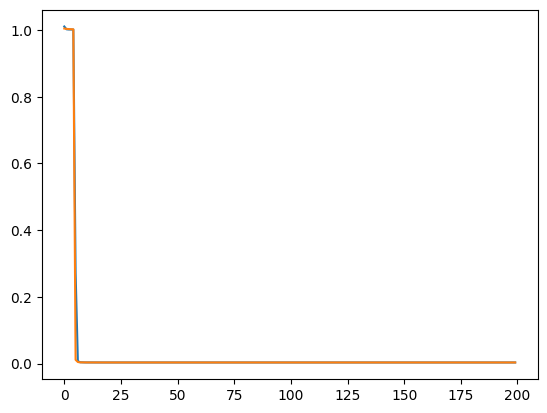

In [43]:
# Actually train
ae = AutoEncoder(latent_space).to(device)
optimizer = optim.Adam(ae.parameters(), lr=ADAM_LR, weight_decay=weight_decay)

train_losses, validation_losses = train_autoencoder(ae, 
                                                    zoom_train_loader, 
                                                    test_loader, 
                                                    num_epochs=200, 
                                                    flavor_text="SSIM_200", 
                                                    learning_rate=ADAM_LR, 
                                                    weight_decay=weight_decay, 
                                                    device=device)
plt.plot(train_losses)
plt.plot(validation_losses)


In [13]:
# If you want to load a model
ae_load = load_model("../trained_models/20250109_124904_LeakyRELU_200_at_epoch_199_seed_1263811726978100.pth", 100)
# Sanity check to see if model load = success
print(ae_load.state_dict().keys())


odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder.4.weight', 'encoder.4.bias', 'encoder.6.weight', 'encoder.6.bias', 'encoder.8.weight', 'encoder.8.bias', 'encoder.10.weight', 'encoder.10.bias', 'encoder.12.weight', 'encoder.12.bias', 'encoder.14.weight', 'encoder.14.bias', 'encoder.16.weight', 'encoder.16.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder.4.weight', 'decoder.4.bias', 'decoder.6.weight', 'decoder.6.bias', 'decoder.8.weight', 'decoder.8.bias', 'decoder.10.weight', 'decoder.10.bias', 'decoder.12.weight', 'decoder.12.bias', 'decoder.14.weight', 'decoder.14.bias', 'decoder.16.weight', 'decoder.16.bias'])


C:\Users\Askou\AppData\Local\Temp\ipykernel_47284\1626231244.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


# Testing with Mean as threshold

 Reconstruction error threshold = 0.005810087081044912
Accuracy = 0.6962025316455697


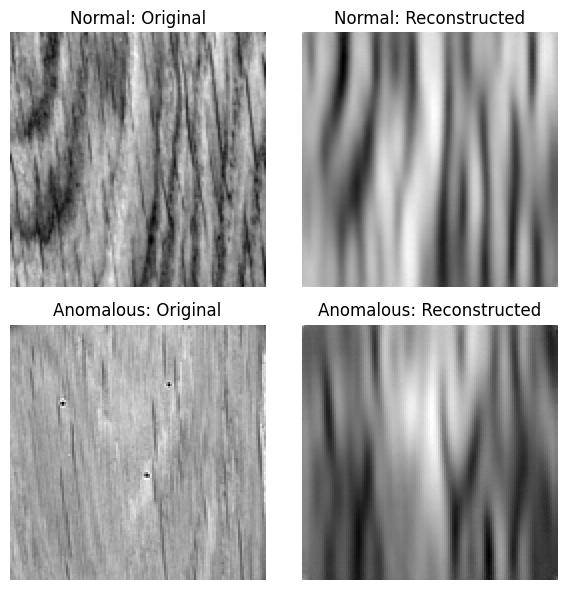

In [15]:
# swap the test_loader for others loaders to see accuracy on anomaly-free images etc.
anomaly_threshold = get_anomaly_value(ae_load, test_loader, device=device)
print(f" Reconstruction error threshold = {anomaly_threshold}")
all_images, p, t, r = get_predictions(ae_load, test_loader, anomaly_threshold, device, True)
print(f"Accuracy = {np.mean(p == t)}")

plot_original_and_reconstructed_with_anomalies(ae_load, test_loader, device, num_images=1)

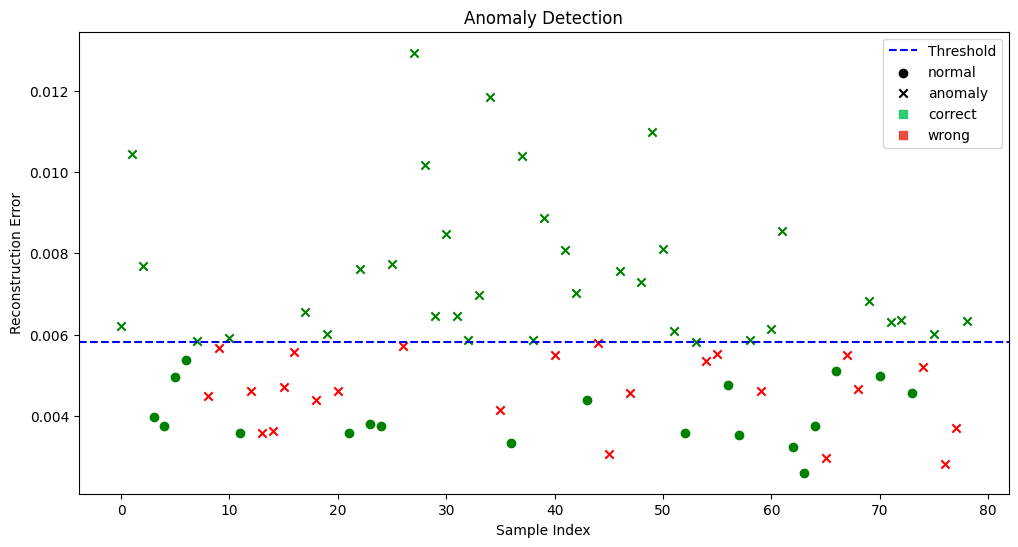

In [16]:
plot_reconstruction_error1(anomaly_threshold, r, t, p)


# Finding threshold based on error distribution

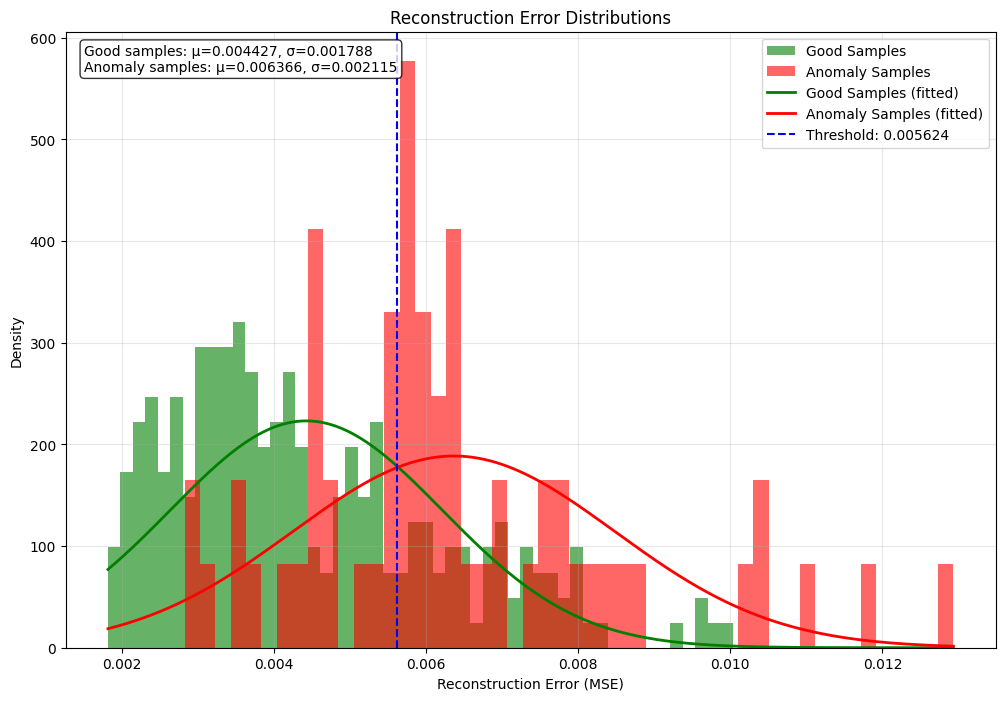

In [17]:
threshold, good_errors, anomaly_errors = find_optimal_threshold(
    ae_load,
    train_loader,
    anomalous_test_loader,
    device='cpu',
    num_bins=50
)

Accuracy = 0.7341772151898734


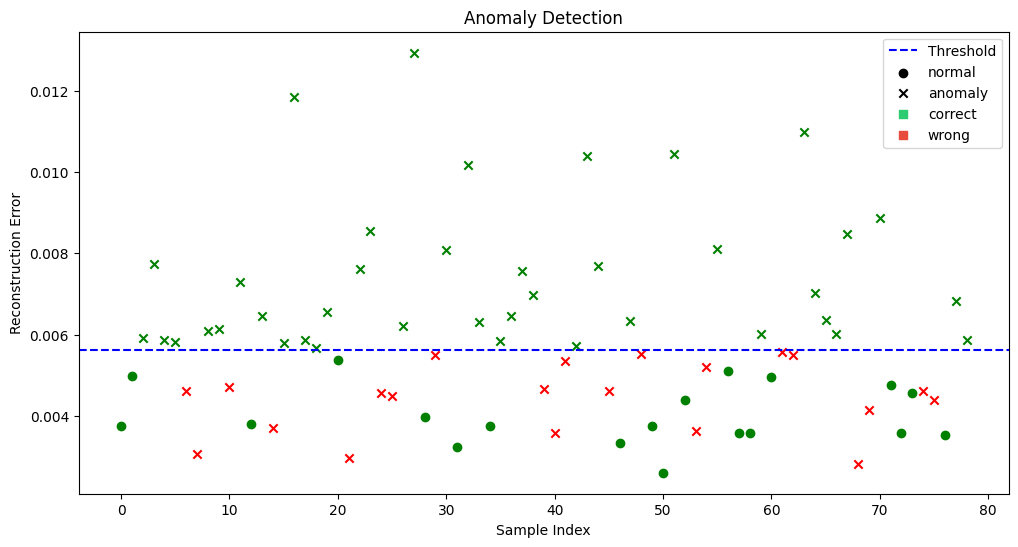

In [18]:
all_images, p, t, r = get_predictions(ae_load, test_loader, threshold, device, True)
print(f"Accuracy = {np.mean(p == t)}")
plot_reconstruction_error1(threshold, r, t, p)
